# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.  

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<b>Цель проекта:</b> изучение параметров, влияющих на стоимость квартир. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

### Изучение общей информации

!pip install pandas -U
!pip install numpy -U
!pip install matplotlib -U

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv("datasets/real_estate_data.csv", sep="\t")
original_df = pd.read_csv("datasets/real_estate_data.csv", sep="\t")

In [4]:
df.info()
print()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Для более простого визуального восприятия выразим цены квартир в миллионах

In [5]:
last_price_mln = np.round(df['last_price']/1000000, 6)
df.insert(2, 'last_price_mln', last_price_mln)

In [6]:
display(df.describe())

,total_images,last_price,last_price_mln,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,6.541549,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,10.887013,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,0.012190,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,3.400000,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,4.650000,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,6.800000,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,763.000000,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Обращают на себя внимание следующие столбцы:
- last_price: минимальные и максимальные значения вызывают подозрения: 12 тыс. и 763 млн руб. соответственно
- total_area: 900 квадратных метров - очень много для квартиры
- rooms: есть квартира(ы) с 19 комнатами, есть квартира(ы) с 0 комнатами - вероятно это студии. Проверим это далее.
- ceiling_height: минимальные и максимальные значения в высоте потолков также вызывают подозрения (1 метр и 100 метров)
- is_apartment: имеет тип object, хотя по своему смыслу это булево значение
- Перечисленные далее столбцы имеют тип float64, но в этом нет никакой дополнительной ценности.
    - balcony
    - airports_nearest
    - cityCenters_nearest 
    - parks_around3000
    - parks_nearest
    - ponds_around3000
    - ponds_nearest
    - days_exposition
    - parks_around3000

<b>Выводы</b>

Данные включают статистику по 23 699 объявлениям. Есть множество пропусков в столбцах. Множество параметров, описанных выше, указывают, что некоторые объявления - ненастоящие, сделаны случайно, имеют технические ошибки, то есть являются выбросами. Также создается впечатление, что есть квартиры "элитарного характера", параметры которых не подчиняются общим правилам, применяемыми для остальных квартир.

### Предобработка данных

Для начала построим гистограмму цен на квартиры

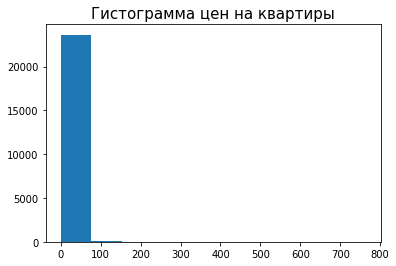

In [7]:
plt.hist(df['last_price_mln'])
plt.title('Гистограмма цен на квартиры', fontsize=15)
plt.show()

Такой график не информативный, тем не менее он еще раз напоминает нам о странных ценниках. Рассмотрим сначала самые высокие ценники

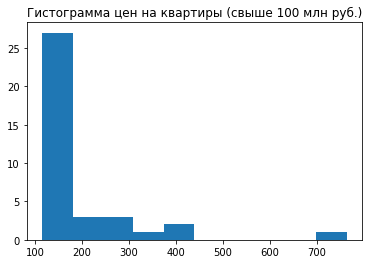

In [8]:
plt.hist(df[df['last_price_mln'] > 100]['last_price_mln'])
plt.title('Гистограмма цен на квартиры (свыше 100 млн руб.)', fontsize=12)
plt.show()

Подозрительно выглядят значения за пределами 700 млн руб.

In [9]:
display(df[df['last_price_mln'] > 700])

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,763.0,400.0,2017-09-30T00:00:00,7,NaN,10.0,250.0,10,NaN,False,False,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0


763 млн руб. безусловно много для квартиры, но с учетом близости к центру и метража можно считать это возможным. Однако это индивидуальные предложения, неподчиняющиеся общим правилам, и для конечной цели определения параметров, влияющих на цену, это не подходит. Исключим из выборки.

In [10]:
df = df[df['last_price_mln'] < 700].reset_index(drop=True)

In [11]:
df[df['last_price_mln'] > 700].shape[0]

0

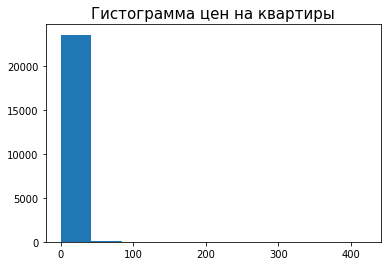

In [12]:
plt.hist(df['last_price_mln'])
plt.title('Гистограмма цен на квартиры', fontsize=15)
plt.show()

Рассмотрим подозрительно малые ценники

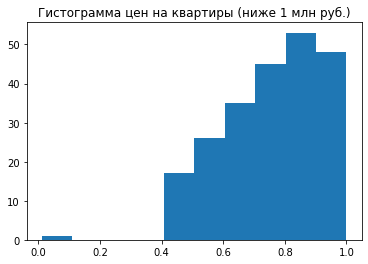

In [13]:
plt.hist(df[df['last_price_mln'] < 1]['last_price_mln'])
plt.title('Гистограмма цен на квартиры (ниже 1 млн руб.)', fontsize=12)
plt.show()

In [14]:
display(df[df['last_price_mln'] < 0.2])

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12190.0,0.01219,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


Возможно, это квартира не на продажу, а на съем. Избавимся.

In [15]:
df = df[(df['last_price_mln'] > 0.2) |
        df['last_price_mln'].isna()].reset_index(drop=True)

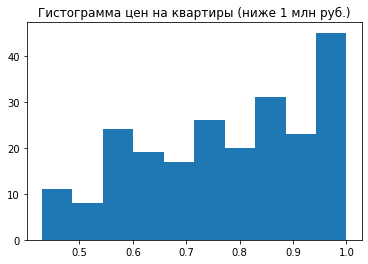

In [16]:
plt.hist(df[df['last_price_mln'] < 1]['last_price_mln'])
plt.title('Гистограмма цен на квартиры (ниже 1 млн руб.)', fontsize=12)
plt.show()

#### Слишком низкие и высокие потолки

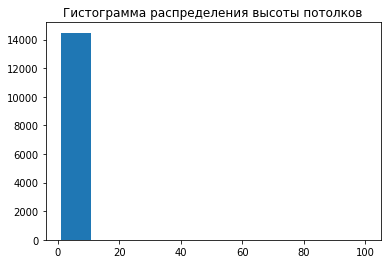

In [17]:
plt.hist(df['ceiling_height'])
plt.title('Гистограмма распределения высоты потолков')
plt.show()

Сначала рассмотрим слишком высокие потолки

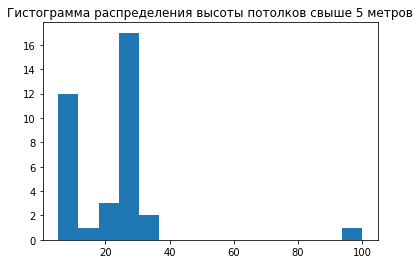

In [18]:
plt.hist(df[df['ceiling_height'] > 5]['ceiling_height'], bins=15)
plt.title('Гистограмма распределения высоты потолков свыше 5 метров')
plt.show()

Что ж, можно смириться с потолками в 30+ метров, но не со 100

In [19]:
display(df[df['ceiling_height'] > 90])

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22867,0,15000000.0,15.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Изображений нет, понимания, что это, тоже. Избавимся.

In [20]:
df = df[(df['ceiling_height'] < 90) |
        df['ceiling_height'].isna()].reset_index(drop=True)

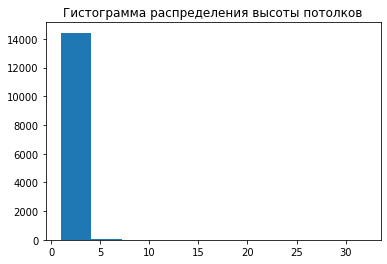

In [21]:
plt.hist(df['ceiling_height'])
plt.title('Гистограмма распределения высоты потолков')
plt.show()

Рассмотрим слишком низкие потолки

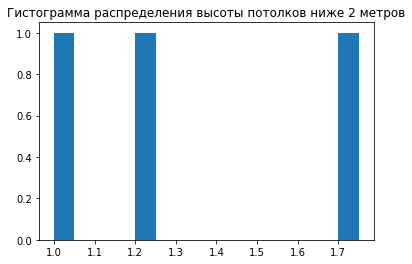

In [22]:
plt.hist(df[df['ceiling_height'] < 2]['ceiling_height'], bins=15)
plt.title('Гистограмма распределения высоты потолков ниже 2 метров')
plt.show()

Все это выглядит подозрительно.

In [23]:
df = df[(df['ceiling_height'] > 2) |
        df['ceiling_height'].isna()].reset_index(drop=True)

#### Объявления о квартирах с минимальным размером площади

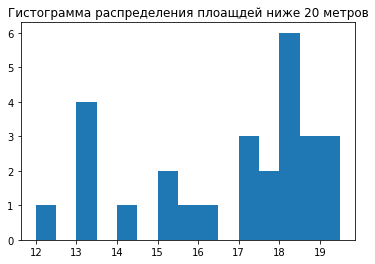

In [24]:
plt.hist(df[df['total_area'] < 20]['total_area'], bins=15)
plt.title('Гистограмма распределения плоащдей ниже 20 метров')
plt.show()

Избавимся от квартир площадью меньше 17 метров

In [25]:
df = df[(df['total_area'] > 17) |
        df['total_area'].isna()].reset_index(drop=True)

#### Объявления о квартирах без единой комнаты

Отдельно рассмотрим объевления с квартирами без единой комнаты, так как в дальнейшем следует понимать, что они из себя представляют.

In [26]:
df[df['rooms'] == 0]['studio'].value_counts()

True     136
False     58
Name: studio, dtype: int64

Попробуем рассмотреть дальше, что представляют собой 59 квартир - не студий, но с 0 комнатами

In [27]:
display(df[(df['rooms'] == 0) & (df['studio'] == False)].head(5))

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
349,4,2320000.0,2.320,25.0,2017-09-27T00:00:00,0,NaN,14.0,17.0,1,NaN,False,True,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
508,0,3375000.0,3.375,34.4,2017-03-28T00:00:00,0,NaN,26.0,24.3,19,NaN,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
778,9,2600000.0,2.600,26.1,2018-02-20T00:00:00,0,NaN,18.0,NaN,8,NaN,False,True,NaN,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
837,14,1900000.0,1.900,35.0,2017-04-14T00:00:00,0,2.7,5.0,15.0,3,False,False,True,NaN,1.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0
944,5,2200000.0,2.200,23.0,2016-09-27T00:00:00,0,NaN,27.0,18.0,7,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,483.0


Скорее всего, это просто квартиры с открытой планировкой.

In [28]:
display(df[(df['rooms'] == 0) & (df['studio'] == False)]
        ['open_plan'].value_counts())

True    58
Name: open_plan, dtype: int64

Мы подтвердили, что все квартиры с 0 комнатами или являются квартирами-студиями или имеют открытую планировку

In [29]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23670 entries, 0 to 23669
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23670 non-null  int64  
 1   last_price            23670 non-null  float64
 2   last_price_mln        23670 non-null  float64
 3   total_area            23670 non-null  float64
 4   first_day_exposition  23670 non-null  object 
 5   rooms                 23670 non-null  int64  
 6   ceiling_height        14481 non-null  float64
 7   floors_total          23584 non-null  float64
 8   living_area           21774 non-null  float64
 9   floor                 23670 non-null  int64  
 10  is_apartment          2771 non-null   object 
 11  studio                23670 non-null  bool   
 12  open_plan             23670 non-null  bool   
 13  kitchen_area          21405 non-null  float64
 14  balcony               12173 non-null  float64
 15  locality_name      

None

В выборке было 23 699 значений, стало 23670

### Обработка пропусков

Для начала посмотрим, где есть пропуски

In [30]:
report = df.isna().sum().to_frame()
report = report.rename(columns={0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df.shape[0]).round(2)
report.sort_values(by='missing_values', ascending=False)
display(report)

,missing_values,% of total
total_images,0,0.00
last_price,0,0.00
last_price_mln,0,0.00
total_area,0,0.00
first_day_exposition,0,0.00
rooms,0,0.00
ceiling_height,9189,0.39
floors_total,86,0.00
living_area,1896,0.08
floor,0,0.00


#### ceiling_height

Мы видим пропуски в столбце "ceiling_height". 
У нас есть несколько вариантов действия:
1. оставить пропуски, как есть
2. найти какие-то взаимосвязи в существующих данных и заполнить пропуски на их основании
3. заполнить медианным, средним или наиболее часто встречаемым значением, то есть модой

In [31]:
df['ceiling_height'].value_counts(dropna=False).head(10)

NaN     9189
2.50    3514
2.60    1645
2.70    1572
3.00    1112
2.80     993
2.55     979
2.75     908
2.65     676
3.20     277
Name: ceiling_height, dtype: int64

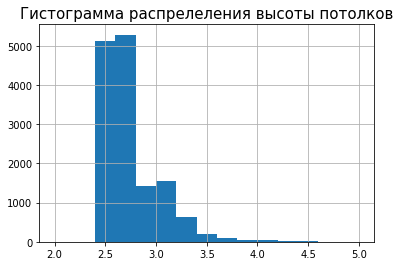

In [32]:
df['ceiling_height'].hist(range=(2, 5), bins=15)
plt.title('Гистограмма распрелеления высоты потолков', fontsize=15)
plt.show()

In [33]:
df.corr()['ceiling_height']

total_images           0.009670
last_price             0.105434
last_price_mln         0.105434
total_area             0.130976
rooms                  0.077805
ceiling_height         1.000000
floors_total          -0.031599
living_area            0.124717
floor                 -0.014541
studio                 0.002700
open_plan              0.055908
kitchen_area           0.118157
balcony                0.017194
airports_nearest      -0.040066
cityCenters_nearest   -0.128062
parks_around3000       0.092694
parks_nearest         -0.019139
ponds_around3000       0.092142
ponds_nearest         -0.073044
days_exposition        0.033204
Name: ceiling_height, dtype: float64

Существенной корреляции высоты потолков с другими столбцами не обнаружено. Здравый смысл подсказывает, что потолки могут зависить, в первую очередь, от года постройки здания (и конечно от города, этажности здания, близости к центру, но опять же при условии наличия года постройки). Такой информации у нас нет.
Оставим значения как есть.

#### floors_total

In [34]:
print(df.isna().sum())

total_images                0
last_price                  0
last_price_mln              0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9189
floors_total               86
living_area              1896
floor                       0
is_apartment            20899
studio                      0
open_plan                   0
kitchen_area             2265
balcony                 11497
locality_name              49
airports_nearest         5532
cityCenters_nearest      5509
parks_around3000         5508
parks_nearest           15602
ponds_around3000         5508
ponds_nearest           14573
days_exposition          3178
dtype: int64


Пропусков в столбце не очень много - 86.

In [35]:
df[df['floors_total'].isna()].isna().sum()

total_images             0
last_price               0
last_price_mln           0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height          77
floors_total            86
living_area             33
floor                    0
is_apartment            86
studio                   0
open_plan                0
kitchen_area            47
balcony                 39
locality_name            1
airports_nearest        10
cityCenters_nearest     10
parks_around3000        10
parks_nearest           52
ponds_around3000        10
ponds_nearest           37
days_exposition          9
dtype: int64

In [36]:
print('Доля строк с пропущенным значениям общего кол-ва этажей:',
      '{:.2%}'.format(86/len(df)))

Доля строк с пропущенным значениям общего кол-ва этажей: 0.36%


Удалим данные строки

In [37]:
df.dropna(subset=['floors_total'], inplace=True)
print(df.isna().sum())

total_images                0
last_price                  0
last_price_mln              0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9112
floors_total                0
living_area              1863
floor                       0
is_apartment            20813
studio                      0
open_plan                   0
kitchen_area             2218
balcony                 11458
locality_name              48
airports_nearest         5522
cityCenters_nearest      5499
parks_around3000         5498
parks_nearest           15550
ponds_around3000         5498
ponds_nearest           14536
days_exposition          3169
dtype: int64


#### living_area

Предполагаем, что итоговая площадь квартиры равная сумме площадей кухни, жилой площади, плоащди коридоров, балконов и санузлов. Соответственно сумма площадей кухни и жилой площади должна быть не больше итоговой площади. Рассчитаем размер "прочей площади" с использованием 'sub' во избежание возникновения NaN.

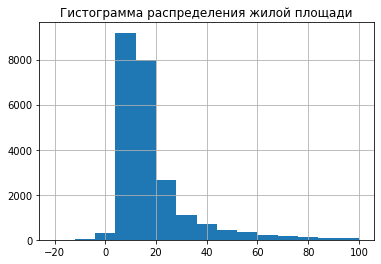

In [38]:
df['other_area'] = df['total_area'].sub(
    df['kitchen_area'], fill_value=0).sub(df['living_area'], fill_value=0)
df['other_area'].hist(bins=15, range=(-20, 100))
plt.title('Гистограмма распределения жилой площади')
plt.show()

Есть квартиры, где гипотеза не находит своего подтвреждения (разность меньше нуля). Необходимо выяснить, с чем это связано.

In [39]:
df[df['other_area'] < 0].info()
display(df[df['other_area'] < 0].describe())
display(df[df['other_area'] < 0].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 184 to 23173
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          65 non-null     int64  
 1   last_price            65 non-null     float64
 2   last_price_mln        65 non-null     float64
 3   total_area            65 non-null     float64
 4   first_day_exposition  65 non-null     object 
 5   rooms                 65 non-null     int64  
 6   ceiling_height        42 non-null     float64
 7   floors_total          65 non-null     float64
 8   living_area           65 non-null     float64
 9   floor                 65 non-null     int64  
 10  is_apartment          17 non-null     object 
 11  studio                65 non-null     bool   
 12  open_plan             65 non-null     bool   
 13  kitchen_area          65 non-null     float64
 14  balcony               44 non-null     float64
 15  locality_name       

,total_images,last_price,last_price_mln,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,other_area
count,65.000000,6.500000e+01,65.000000,65.000000,65.000000,42.00000,65.000000,65.000000,65.000000,65.000000,44.000000,45.000000,45.000000,45.000000,19.000000,45.000000,18.000000,57.000000,6.500000e+01
mean,10.353846,5.460291e+06,5.460291,50.232615,1.707692,3.92119,12.784615,41.662462,7.892308,14.838615,1.522727,28994.311111,14036.955556,0.644444,433.473684,0.777778,591.666667,160.543860,-6.268462e+00
std,6.003725,3.872811e+06,3.872811,21.289782,0.764916,5.29015,7.674007,17.190025,5.692987,8.671434,0.952076,12680.896419,6817.999050,0.908434,494.053457,1.105542,320.625308,195.839773,5.628152e+00
min,0.000000,1.230000e+06,1.230000,20.670000,1.000000,2.50000,2.000000,14.170000,1.000000,5.000000,0.000000,9731.000000,1884.000000,0.000000,68.000000,0.000000,80.000000,3.000000,-2.980000e+01
25%,6.000000,3.250000e+06,3.250000,37.000000,1.000000,2.60000,5.000000,30.600000,3.000000,8.600000,1.000000,17827.000000,9760.000000,0.000000,175.000000,0.000000,384.250000,46.000000,-8.120000e+00
50%,10.000000,4.700000e+06,4.700000,42.500000,2.000000,2.70000,12.000000,36.900000,6.000000,12.000000,2.000000,29683.000000,14240.000000,0.000000,253.000000,0.000000,526.000000,93.000000,-5.500000e+00
75%,15.000000,6.299000e+06,6.299000,60.200000,2.000000,2.80000,17.000000,51.000000,12.000000,19.000000,2.000000,37180.000000,15824.000000,1.000000,509.500000,1.000000,832.250000,163.000000,-2.100000e+00
max,20.000000,2.750000e+07,27.500000,141.200000,3.000000,27.50000,35.000000,106.400000,25.000000,43.400000,5.000000,54160.000000,35259.000000,3.000000,2295.000000,3.000000,1250.000000,940.000000,-1.421085e-14


,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,other_area
184,7,2600000.0,2.60000,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,False,False,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0,-2.10
545,9,4700000.0,4.70000,23.80,2018-12-28T00:00:00,1,NaN,18.0,20.00,9,NaN,False,False,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0,-1.20
551,8,3100000.0,3.10000,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,False,False,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0,-8.24
600,12,5600000.0,5.60000,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,NaN,False,False,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0,-1.60
695,1,3364930.0,3.36493,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,False,False,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0,-12.17


Всего 65 квартир. Причины, с чем это связано, не наблюдается. Скорее всего, выложившие объявление хотели завысить свою жилую площадь. Так как мы не знаем точных причин, а строчек немного, удалим строки.

In [40]:
df = df.drop(df[df['other_area'] < 0].index).reset_index(drop=True)
display(df[df['other_area'] < 0].count())

total_images            0
last_price              0
last_price_mln          0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
other_area              0
dtype: int64

Предполагаем, что жилая площадь во многом зависит от типа планировки, кол-ва комнат, общей площади, площади кухни. 
Соответственно делаем гиптотезу, что при отрытой планировке мы не найдем (или найдем очень мало) заполненных значений жилой площади. Проверим нашу гипотезу.

In [41]:
df[df['open_plan'] == True]['living_area'].value_counts(dropna=False).head()

18.0    11
NaN      5
20.0     5
17.0     5
15.0     4
Name: living_area, dtype: int64

Гипотеза не нашла своего подтверждения. Только 5 пропущенных значений.

Посмотрим, в каких столбцах встречаются пропуски вместе с пропусками жилой площади

In [42]:
df[df['living_area'].isna()].isna().sum()

total_images               0
last_price                 0
last_price_mln             0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height          1075
floors_total               0
living_area             1863
floor                      0
is_apartment            1744
studio                     0
open_plan                  0
kitchen_area            1424
balcony                 1383
locality_name              5
airports_nearest         616
cityCenters_nearest      614
parks_around3000         614
parks_nearest           1301
ponds_around3000         614
ponds_nearest           1188
days_exposition          195
other_area                 0
dtype: int64

Обращает на себя внимание тот факт, что там где пропущено значение жилой площади, нет ни одного пропущеного значения общей площади и кол-ва комнат. Это можно использовать. Логично предположить, что с увеличением кол-ва комнат будет увеличиваться доля жилой площади (не распространяется на студии). Проверим нашу гипотезу.

In [43]:
df['living_area_share'] = df['living_area']/df['total_area']

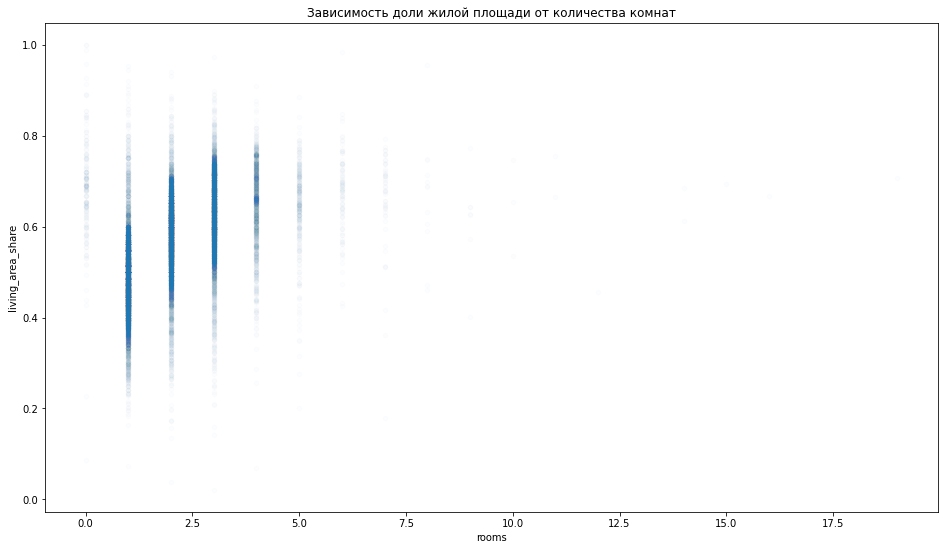

In [44]:
df.plot(x='rooms', y='living_area_share',
        kind='scatter', figsize=(16, 9), alpha=0.01)
plt.title('Зависимость доли жилой площади от количества комнат')
plt.show()

Можно заметить, как центр разброса становится выше по оси y. Гипотеза подвтерждается.

In [45]:
display(df.groupby('rooms')['living_area_share'].median())

rooms
0     0.689530
1     0.482015
2     0.584906
3     0.631614
4     0.659740
5     0.651842
6     0.679509
7     0.684242
8     0.688475
9     0.628251
10    0.653103
11    0.710093
12    0.455222
14    0.648695
15    0.693220
16    0.666667
19    0.706086
Name: living_area_share, dtype: float64

Если смотреть на сводную таблицу выше, то можно заметить, что по медианное значение доли жилой площади действительно возрастает с увеличением кол-ва комнат до появления в выборке квартир с 9 комнатами. Данная тенденция не касается квартир с 0 комнатами, которые, как выяснилось раннее, либо имеют открытую планировку, либо являются студиями. Создадим столбец с медианным значением доли жилой площади в для данного значения комнат. 

In [46]:
df['living_area_median_share'] = df.groupby(
    'rooms')['living_area_share'].transform('median')

Далее нужно создать функцию для заполнения пропусков в жилой площади в зависимости от количества комнат квартиры, учитывающую условие, что сумма жилой площади и кухни не должна быть боль общей площади квартиры. Но прежде выясним, какая в среднем доля площади кухни от нежилой площади.

In [47]:
df['not_living_area'] = df['total_area'] - df['living_area']
df['kitchen_area_share_of_not_living_area'] = df['kitchen_area'] / \
    df['not_living_area']
display(df.groupby('rooms')['kitchen_area_share_of_not_living_area'].median())
df['kitchen_area_share_of_not_living_area_median'] = df.groupby(
    'rooms')['kitchen_area_share_of_not_living_area'].transform('median')

rooms
0          NaN
1     0.472973
2     0.400000
3     0.359788
4     0.340557
5     0.311586
6     0.314286
7     0.298246
8     0.356164
9     0.133477
10    0.298211
11    0.239505
12    0.228432
14    0.226829
15    0.552486
16    0.144444
19    0.250681
Name: kitchen_area_share_of_not_living_area, dtype: float64

Обращает на себя внимание тот факт, что в студиях и открытых планировках доля площади кухни получила значение NaN. Заменим пропуски нулями.

In [48]:
df['kitchen_area_share_of_not_living_area_median'].fillna(0, inplace=True)

In [49]:
def living_area(row):
    if pd.isna(row['living_area']):
        if row['living_area_median_share'] * row['total_area'] + row['kitchen_area'] >= row['total_area']:
            return row['total_area'] - row['kitchen_area'] / row['kitchen_area_share_of_not_living_area_median']
        else:
            return row['living_area_median_share'] * row['total_area']
    else:
        return row['living_area']


df['living_area'] = df.apply(living_area, axis=1)

df['living_area'].isna().sum()

0

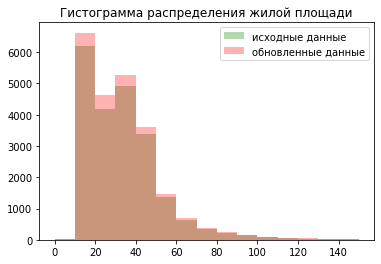

In [50]:
fig, ax = plt.subplots()
plt.hist(original_df['living_area'], alpha=0.3, bins=15,
         range=(0, 150), label='graph1', color='g')
plt.hist(df['living_area'], alpha=0.3, bins=15,
         range=(0, 150), label='graph2', color='r')
plt.legend(['исходные данные', 'обновленные данные'], loc='upper right')
plt.title('Гистограмма распределения жилой площади')
plt.show()

Обращаем внимание, что распределение "жилой площади" в целом схоже с тем, что было до обработки пропусков. Это один из признаков того, что пропуски были заполнены довольно точно. 


In [51]:
df.isna().sum()

total_images                                        0
last_price                                          0
last_price_mln                                      0
total_area                                          0
first_day_exposition                                0
rooms                                               0
ceiling_height                                   9089
floors_total                                        0
living_area                                         0
floor                                               0
is_apartment                                    20765
studio                                              0
open_plan                                           0
kitchen_area                                     2218
balcony                                         11437
locality_name                                      48
airports_nearest                                 5502
cityCenters_nearest                              5479
parks_around3000            

#### is_apartment

In [52]:
df['is_apartment'].value_counts(dropna=False)

NaN      20765
False     2705
True        49
Name: is_apartment, dtype: int64

Предполагаем, что пропущенные значения означают, что квартира не является апартаментами

In [53]:
df['is_apartment'].fillna(False, inplace=True)
df.isna().sum()

total_images                                        0
last_price                                          0
last_price_mln                                      0
total_area                                          0
first_day_exposition                                0
rooms                                               0
ceiling_height                                   9089
floors_total                                        0
living_area                                         0
floor                                               0
is_apartment                                        0
studio                                              0
open_plan                                           0
kitchen_area                                     2218
balcony                                         11437
locality_name                                      48
airports_nearest                                 5502
cityCenters_nearest                              5479
parks_around3000            

#### kitchen_area

Теперь заполним площадь кухни на основании типа квартиры и нежилой плоащади

In [54]:
df['not_living_area'] = df['total_area'] - df['living_area']


def kitchen_area(row):
    if pd.isna(row['kitchen_area']):
        if row['studio'] == True:
            return 0
        elif row['open_plan'] == True:
            return 0
        else:
            return row['not_living_area'] * row['kitchen_area_share_of_not_living_area_median']
    else:
        return row['kitchen_area']


df['kitchen_area'] = df.apply(kitchen_area, axis=1)

df.isna().sum()
print(df['kitchen_area'].describe())

count    23519.000000
mean        10.382213
std          5.901183
min          0.000000
25%          7.000000
50%          9.000000
75%         11.800000
max        121.050949
Name: kitchen_area, dtype: float64


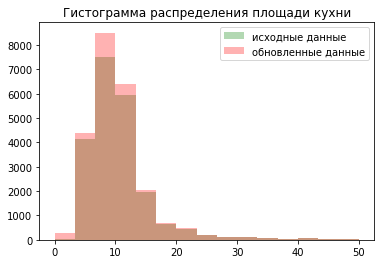

In [55]:
fig, ax = plt.subplots()
plt.hist(original_df['kitchen_area'], alpha=0.3, bins=15,
         range=(0, 50), label='graph1', color='g')
plt.hist(df['kitchen_area'], alpha=0.3, bins=15,
         range=(0, 50), label='graph2', color='r')
plt.legend(['исходные данные', 'обновленные данные'], loc='upper right')
plt.title('Гистограмма распределения площади кухни')
plt.show()

Обращаем внимание, что распределение "площади кухни" в целом схоже с тем, что было до обработки пропусков. 

Сделаем пару проверок.

 Рассмотрим внимательнее, что за квартиры с площадью кухни равной 0 метров.

<div class="alert alert-info"> <b>Комментарий студента:</b> Использовал двойное неравенство, потому что питон (как и многие другие языки) иногда выдает интересные результаты вычислений. Ниже будет пример, когда появляется ничтожно малое число, но не ноль... </div>

In [56]:
print(df[(df['kitchen_area'] < 0.1) & (df['kitchen_area'] > -0.1)]
      ['kitchen_area'].value_counts())
print(df[(df['kitchen_area'] < 0.1) & (df['kitchen_area'] > -0.1)]
      ['studio'].value_counts())
print(df[(df['kitchen_area'] < 0.1) & (df['kitchen_area'] > -0.1)]
      ['open_plan'].value_counts())
print(df[df['open_plan'] == True]['kitchen_area'].value_counts())
print(df[df['studio'] == True]['kitchen_area'].value_counts())

0.0    210
Name: kitchen_area, dtype: int64
True     144
False     66
Name: studio, dtype: int64
False    144
True      66
Name: open_plan, dtype: int64
0.0    66
Name: kitchen_area, dtype: int64
0.0    144
Name: kitchen_area, dtype: int64


Как мы видим, все квартиры с нулевой площадью кухни являются либо студиями, либо квартирами с открытой планировкой. Верно и наоборот.
Далее рассмотрим, что представляют собой квартиры с площадью кухни меньше двух метров.

In [57]:
display(df[(df['kitchen_area'] <= 2) & (df['kitchen_area'] != 0)].describe())
display(df[(df['kitchen_area'] <= 2) & (df['kitchen_area'] != 0)].head(5))

,total_images,last_price,last_price_mln,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,other_area,living_area_share,living_area_median_share,not_living_area,kitchen_area_share_of_not_living_area,kitchen_area_share_of_not_living_area_median
count,22.000000,2.200000e+01,22.000000,22.000000,22.000000,9.000000,22.000000,22.000000,22.000000,22.000000,8.000000,16.000000,16.000000,16.000000,7.000000,16.000000,11.000000,21.000000,22.000000,22.000000,22.000000,22.000000,7.000000,22.000000
mean,6.954545,3.760318e+06,3.760318,35.269545,1.454545,2.922222,11.818182,30.767273,7.454545,1.537092,0.375000,23351.812500,10543.875000,0.750000,460.428571,0.937500,514.454545,112.952381,3.897727,0.838464,0.511823,4.502273,0.370503,0.450664
std,5.232474,2.705554e+06,2.705554,21.483608,1.143398,0.341056,7.359065,22.420756,6.246731,0.485366,0.744024,8547.076508,6057.237026,0.930949,176.552029,0.853913,302.187149,93.433118,2.890007,0.122956,0.059199,3.373178,0.282125,0.045260
min,0.000000,1.150000e+06,1.150000,17.600000,1.000000,2.500000,3.000000,14.000000,1.000000,0.534286,0.000000,11761.000000,1967.000000,0.000000,231.000000,0.000000,45.000000,10.000000,0.290000,0.500000,0.482015,1.700000,0.125000,0.314286
25%,3.250000,2.283000e+06,2.283000,23.072500,1.000000,2.750000,5.000000,16.000000,1.000000,1.247297,0.000000,17984.000000,4802.000000,0.000000,344.500000,0.000000,360.000000,44.000000,2.000000,0.806522,0.482015,2.367500,0.183333,0.472973
50%,6.000000,2.910000e+06,2.910000,27.180000,1.000000,2.800000,13.000000,20.500000,6.500000,1.600000,0.000000,20968.000000,12403.500000,0.000000,426.000000,1.000000,537.000000,107.000000,3.650000,0.868873,0.482015,3.650000,0.250000,0.472973
75%,9.000000,4.050000e+06,4.050000,36.375000,1.000000,3.000000,18.000000,32.900000,11.750000,1.993074,0.250000,31584.500000,15774.000000,2.000000,569.000000,1.000000,698.500000,157.000000,4.000000,0.925673,0.482015,4.127500,0.489247,0.472973
max,19.000000,1.335100e+07,13.351000,102.700000,6.000000,3.500000,25.000000,101.000000,19.000000,2.000000,2.000000,39446.000000,19383.000000,2.000000,739.000000,3.000000,937.000000,355.000000,14.000000,0.983447,0.679509,16.000000,0.873362,0.472973


,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,other_area,living_area_share,living_area_median_share,not_living_area,kitchen_area_share_of_not_living_area,kitchen_area_share_of_not_living_area_median
895,15,2600000.0,2.60,27.0,2017-07-10T00:00:00,1,2.75,23.0,18.0,18,False,False,False,2.000000,0.0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0,7.0,0.666667,0.482015,9.0,0.222222,0.472973
2935,9,2550000.0,2.55,32.0,2017-12-02T00:00:00,1,NaN,14.0,30.2,13,False,False,False,0.851351,1.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,157.0,1.8,0.943750,0.482015,1.8,NaN,0.472973
4307,19,6900000.0,6.90,72.0,2019-03-25T00:00:00,3,3.50,4.0,70.0,1,True,False,False,0.719577,NaN,Санкт-Петербург,31487.0,4466.0,2.0,353.0,1.0,439.0,22.0,2.0,0.972222,0.631614,2.0,NaN,0.359788
6217,9,3100000.0,3.10,24.0,2018-06-25T00:00:00,2,3.00,5.0,16.0,5,False,False,False,2.000000,NaN,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0,6.0,0.666667,0.584906,8.0,0.250000,0.400000
6386,9,1590000.0,1.59,23.0,2018-07-10T00:00:00,1,3.00,18.0,19.0,1,False,False,False,1.891892,NaN,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,67.0,4.0,0.826087,0.482015,4.0,NaN,0.472973


Проверим, были ли такие примеры до обработки.

In [58]:
display(original_df[(original_df['kitchen_area'] <= 2) &
        (original_df['kitchen_area'] != 0)].describe())
display(original_df[(original_df['kitchen_area'] <= 2)
        & (original_df['kitchen_area'] != 0)].head(8))

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,8.000000,8.000000e+00,8.000000,8.000000,4.000000,8.000000,8.000000,8.000000,8.000000,2.0,8.000000,8.000000,8.000000,2.000000,8.000000,5.000000,7.000000
mean,8.125000,3.000000e+06,24.311250,1.125000,2.762500,11.000000,17.262500,7.125000,1.912500,0.0,21353.250000,10387.375000,0.375000,522.500000,0.750000,479.600000,77.000000
std,5.303301,1.303446e+06,5.501546,0.353553,0.205649,7.540368,3.799601,6.174545,0.247487,0.0,9053.684881,5399.525639,0.744024,136.471609,0.707107,441.500623,71.860977
min,2.000000,1.190000e+06,14.000000,1.000000,2.500000,3.000000,11.000000,1.000000,1.300000,0.0,9898.000000,3953.000000,0.000000,426.000000,0.000000,45.000000,4.000000
25%,4.750000,2.417500e+06,22.467500,1.000000,2.687500,5.000000,15.500000,1.000000,2.000000,0.0,16107.000000,4687.500000,0.000000,474.250000,0.000000,69.000000,27.500000
50%,6.500000,2.820000e+06,24.850000,1.000000,2.775000,9.500000,17.000000,7.500000,2.000000,0.0,19257.000000,11921.500000,0.000000,522.500000,1.000000,411.000000,54.000000
75%,10.500000,3.387500e+06,27.375000,1.000000,2.850000,15.250000,19.875000,10.250000,2.000000,0.0,24588.250000,13864.500000,0.250000,570.750000,1.000000,936.000000,108.000000
max,17.000000,5.350000e+06,32.000000,2.000000,3.000000,23.000000,22.600000,18.000000,2.000000,0.0,37199.000000,17459.000000,2.000000,619.000000,2.000000,937.000000,210.000000


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
906,15,2600000.0,27.00,2017-07-10T00:00:00,1,2.75,23.0,18.0,18,NaN,False,False,2.0,0.0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0
6262,9,3100000.0,24.00,2018-06-25T00:00:00,2,3.00,5.0,16.0,5,NaN,False,False,2.0,NaN,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0
9138,17,2920000.0,23.29,2018-12-12T00:00:00,1,NaN,3.0,21.0,1,NaN,False,False,2.0,NaN,Санкт-Петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0
11033,6,5350000.0,32.00,2016-04-20T00:00:00,1,NaN,14.0,16.0,10,NaN,False,False,2.0,0.0,Санкт-Петербург,19008.0,3953.0,0.0,NaN,1.0,69.0,210.0
16367,2,2720000.0,25.70,2017-10-30T00:00:00,1,NaN,19.0,22.6,11,NaN,False,False,2.0,NaN,Санкт-Петербург,14472.0,13268.0,0.0,NaN,0.0,NaN,109.0
19642,5,1190000.0,14.00,2018-07-29T00:00:00,1,NaN,5.0,11.0,1,NaN,False,False,2.0,NaN,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0
20217,7,4250000.0,28.50,2019-05-01T00:00:00,1,2.80,14.0,19.5,10,NaN,False,False,1.3,NaN,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN
21419,4,1870000.0,20.00,2018-03-06T00:00:00,1,2.50,5.0,14.0,1,NaN,False,False,2.0,NaN,Санкт-Петербург,16652.0,15654.0,1.0,619.0,1.0,937.0,45.0


Вообще квартиры с площадью кухни меньше 2 метров были и раньше. 8 квартир, но из этих 8 было 7 однушек, чего не скажешь о новых данных.

In [59]:
df[(df['kitchen_area'] <= 2) & (df['kitchen_area'] != 0)].pivot_table(
    index='total_area', values='rooms', aggfunc='count').head(10)

,rooms
total_area,
17.60,1
17.78,1
18.90,1
20.00,2
23.00,1
23.29,1
23.30,1
24.00,1
25.70,1


В общем, у обработки пропусков есть свои минусы. Удалим все квартиры с площадью кухни меньше двух метров.

In [60]:
df = df.drop(df[(df['kitchen_area'] <= 2) & (
    df['kitchen_area'] != 0)].index).reset_index(drop=True)

In [61]:
df = df.drop(['other_area', 'living_area_share', 'living_area_median_share', 'not_living_area',
             'kitchen_area_share_of_not_living_area', 'kitchen_area_share_of_not_living_area_median'], axis=1)

Последняя проверка

In [62]:
df['check'] = df['total_area'] - df['living_area'] - df['kitchen_area']
df['check'].describe()

count    2.349700e+04
mean     1.535456e+01
std      1.200629e+01
min     -3.552714e-15
25%      9.500000e+00
50%      1.260000e+01
75%      1.760000e+01
max      3.783000e+02
Name: check, dtype: float64

Мы получили какое-то ничтожно маленькое отрицательно число. Будем считать, что все успешно.

In [63]:
df.isna().sum()

total_images                0
last_price                  0
last_price_mln              0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9076
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11423
locality_name              48
airports_nearest         5496
cityCenters_nearest      5473
parks_around3000         5472
parks_nearest           15489
ponds_around3000         5472
ponds_nearest           14478
days_exposition          3160
check                       0
dtype: int64

In [64]:
df = df.drop(['check'], axis=1)

#### balcony

In [65]:
df['balcony'].value_counts(dropna=False)

NaN    11423
1.0     4178
0.0     3699
2.0     3633
5.0      302
4.0      183
3.0       79
Name: balcony, dtype: int64

Пропуски в столбце balcony, скорее всего, связано с отсутствием балконов

In [66]:
df['balcony'].fillna(0, inplace=True)

In [67]:
df.isna().sum()

total_images                0
last_price                  0
last_price_mln              0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9076
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              48
airports_nearest         5496
cityCenters_nearest      5473
parks_around3000         5472
parks_nearest           15489
ponds_around3000         5472
ponds_nearest           14478
days_exposition          3160
dtype: int64

#### locality_name

48 строк не включают информации о местоположении квартиры. Скорее всего, это техническая ошибка. Удалим данные строки.

In [68]:
df.dropna(subset=['locality_name'], inplace=True)

In [69]:
df.isna().sum()

total_images                0
last_price                  0
last_price_mln              0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9042
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5488
cityCenters_nearest      5465
parks_around3000         5464
parks_nearest           15456
ponds_around3000         5464
ponds_nearest           14455
days_exposition          3159
dtype: int64

In [70]:
df['locality_name'].value_counts().head()

Санкт-Петербург    15578
посёлок Мурино       516
посёлок Шушары       437
Всеволожск           393
Пушкин               369
Name: locality_name, dtype: int64

Также на всякий случай обеспечим написание наименований населенных пунктов одним и тем же способом. Во-первых приведем все к нижнему регистру.

In [71]:
df['locality_name'] = df['locality_name'].str.lower()

In [72]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'e')

In [73]:
df['locality_name'].value_counts().head()

санкт-петербург    15578
посeлок мурино       516
посeлок шушары       437
всеволожск           393
пушкин               369
Name: locality_name, dtype: int64

#### airports_nearest

In [74]:
display(df[df['airports_nearest'].isna()].head(10))

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,2.89,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.400000,5,False,False,False,9.100000,0.0,городской посeлок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,2.90,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.430000,26,False,False,False,8.810000,0.0,посeлок мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,3.89,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.000000,5,False,False,False,9.000000,0.0,сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,5.00,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.000000,15,False,False,False,11.000000,2.0,деревня кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,2.20,32.80,2018-02-19T00:00:00,1,NaN,9.0,15.810098,2,False,False,False,8.035764,0.0,коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,1.99,45.80,2017-10-28T00:00:00,2,2.50,5.0,26.788679,1,False,False,False,7.604528,0.0,поселок городского типа красный бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
38,10,3150000.0,3.15,40.00,2018-03-29T00:00:00,1,2.75,18.0,16.300000,9,False,False,False,11.600000,0.0,посeлок мурино,NaN,NaN,NaN,NaN,NaN,NaN,103.0
47,17,3600000.0,3.60,56.10,2018-10-18T00:00:00,3,NaN,4.0,42.500000,3,False,False,False,5.700000,1.0,гатчина,NaN,NaN,NaN,NaN,NaN,NaN,179.0
60,3,2740000.0,2.74,35.00,2018-01-01T00:00:00,1,NaN,12.0,16.870532,8,False,False,False,8.574748,0.0,посeлок мурино,NaN,NaN,NaN,NaN,NaN,NaN,11.0
62,0,4800000.0,4.80,78.60,2017-09-17T00:00:00,3,2.80,9.0,48.800000,5,False,False,False,11.900000,2.0,сертолово,NaN,NaN,NaN,NaN,NaN,NaN,5.0


Похоже, большинство строк с пропусками представляют объявления о квартирах в поселках, селах

In [75]:
df[df['airports_nearest'].isna()]['locality_name'].value_counts()

посeлок мурино                   516
всеволожск                       393
гатчина                          303
деревня кудрово                  298
выборг                           235
                                ... 
посeлок форт красная горка         1
поселок гончарово                  1
деревня лупполово                  1
поселок пансионат зелeный бор      1
деревня тойворово                  1
Name: locality_name, Length: 344, dtype: int64

Маленький тест на примере поселка Мурино.

In [76]:
df[df['locality_name'] == 'посёлок Мурино']['airports_nearest'].value_counts()

Series([], Name: airports_nearest, dtype: int64)

Для всех объявлений в посёлке Мурино отсутствует информация о расстоянии до аэропорта. Если это информация была бы для нас критически важна, мы бы избрали лучший способ заполнить пропуски - обраться к поставщику данных и сообщить о проблеме. В нашем случае мы оставим данные не тронутыми.

#### cityCenters_nearest 

In [77]:
df[df['cityCenters_nearest'].isna()]['locality_name'].value_counts()

посeлок мурино                   516
всеволожск                       393
гатчина                          303
деревня кудрово                  298
выборг                           235
                                ... 
посeлок форт красная горка         1
поселок гончарово                  1
деревня лупполово                  1
поселок пансионат зелeный бор      1
деревня тойворово                  1
Name: locality_name, Length: 345, dtype: int64

Аналогичная ситуация. Однако не совсем понятно, почему разное количество пропусков с колонкой с расстоянием до аэропорта. Выясним, в каких населенных пунктах расстояние до центра города есть, а расстояни до аэропорта нет.

In [78]:
df[df['airports_nearest'].isna() & df['cityCenters_nearest'].notna()
   ]['locality_name'].value_counts()

санкт-петербург    24
Name: locality_name, dtype: int64

In [79]:
df[df['airports_nearest'].isna() & df['cityCenters_nearest'].notna()
   ]['cityCenters_nearest'].value_counts()

13355.0    8
9734.0     6
5735.0     5
11246.0    2
4892.0     1
21377.0    1
11835.0    1
Name: cityCenters_nearest, dtype: int64

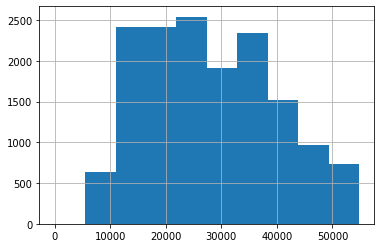

In [80]:
df[df['locality_name'] == 'санкт-петербург']['airports_nearest'].hist()
plt.show()

Мы не сможем заполнить пропуски на основании одного расстояния от центра города. Разброс расстояний до аэропорта для одного Санкт-Петербурга очень большой.

#### parks_around3000

In [81]:
df[df['parks_around3000'].isna()]['locality_name'].value_counts()

посeлок мурино                   516
всеволожск                       393
гатчина                          303
деревня кудрово                  298
выборг                           235
                                ... 
посeлок форт красная горка         1
поселок гончарово                  1
деревня лупполово                  1
поселок пансионат зелeный бор      1
деревня тойворово                  1
Name: locality_name, Length: 344, dtype: int64

In [82]:
df[df['cityCenters_nearest'].isna() & df['parks_around3000'].notna()
   ]['locality_name'].value_counts()

пушкин    1
Name: locality_name, dtype: int64

In [83]:
print(len(df[df['locality_name'] == 'пушкин']))
display(df[(df['locality_name'] == 'пушкин')
        & df['cityCenters_nearest'].isna()])

369


,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20017,2,10500000.0,10.5,85.0,2019-01-08T00:00:00,3,3.0,3.0,55.5,2,False,False,False,8.0,1.0,пушкин,15527.0,NaN,1.0,134.0,0.0,NaN,NaN


Единственная квартира в Пушкине без указания расстояния до центра города, но с указанием расстояния до парка. Возможно, это и есть центр. :) Жаль, что сделать ничего мы с этим не сможем.

#### parks_nearest

In [84]:
df[df['parks_nearest'].isna()]['locality_name'].value_counts()

санкт-петербург               8363
посeлок мурино                 516
посeлок шушары                 437
всеволожск                     393
посeлок парголово              316
                              ... 
поселок станции корнево          1
деревня новолисино               1
деревня большой сабск            1
садовое товарищество садко       1
деревня пчева                    1
Name: locality_name, Length: 364, dtype: int64

Проверим нет ли противоречий.

In [85]:
df[df['parks_nearest'].isna() & (df['parks_around3000'] >= 1)
   ]['locality_name'].value_counts()

Series([], Name: locality_name, dtype: int64)

Противоречий нет. Мы не можем заполнить эту информацию. 

#### ponds_around3000

In [86]:
df[df['ponds_around3000'].isna()]['locality_name'].value_counts()

посeлок мурино                   516
всеволожск                       393
гатчина                          303
деревня кудрово                  298
выборг                           235
                                ... 
посeлок форт красная горка         1
поселок гончарово                  1
деревня лупполово                  1
поселок пансионат зелeный бор      1
деревня тойворово                  1
Name: locality_name, Length: 344, dtype: int64

In [87]:
len(df[df['ponds_around3000'].isna() & df['parks_around3000'].isna()])

5464

Те же квартиры с пропусками, что и в случае парков.

#### ponds_nearest

In [88]:
df[df['ponds_nearest'].isna()]['locality_name'].value_counts()

санкт-петербург            7683
посeлок мурино              516
всеволожск                  393
гатчина                     303
деревня кудрово             298
                           ... 
поселок красносельское        1
поселок станции лужайка       1
деревня хязельки              1
поселок дружноселье           1
деревня пчева                 1
Name: locality_name, Length: 360, dtype: int64

In [89]:
df[df['ponds_nearest'].isna() & (df['ponds_around3000'] >= 1)
   ]['locality_name'].value_counts()

Series([], Name: locality_name, dtype: int64)

Противоречий нет. 
Мы не имеем точного понимания, почему есть пропуски в деревнях и селах (а иногда и в городах). Действительно ли там нет парков, водоемов, аэропортов? Или просто система по каким-то причинам их не учитывает. Ставить ноль не совсем корректно в данной ситуации, так как отсутсвие информации о факторе, потенциально влияющем на цену, не ознаечает отсутствие самого фактора.

#### days_exposition

In [90]:
display(df[df['days_exposition'].isna()].head(10))
display(df[df['days_exposition'].isna()].index.size)

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,13.000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,7.915,71.6,2019-04-18T00:00:00,2,NaN,24.0,41.879245,22,False,False,False,18.900000,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,5.350,40.0,2018-11-18T00:00:00,1,NaN,22.0,19.280608,3,False,False,False,9.799713,1.0,санкт-петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,5.200,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.300000,7,False,False,False,7.000000,0.0,санкт-петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,6.600,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.700000,9,False,False,False,8.300000,2.0,санкт-петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
49,1,3050000.0,3.050,30.8,2018-11-22T00:00:00,1,2.50,9.0,18.000000,7,False,False,False,6.000000,0.0,санкт-петербург,45341.0,16603.0,1.0,675.0,0.0,NaN,NaN
52,20,11795000.0,11.795,136.0,2017-09-22T00:00:00,6,3.00,2.0,94.000000,2,False,False,False,11.000000,1.0,санкт-петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN
71,20,4850000.0,4.850,57.5,2019-03-27T00:00:00,3,2.50,9.0,39.000000,8,False,False,False,6.200000,0.0,санкт-петербург,33623.0,12267.0,1.0,334.0,1.0,333.0,NaN
81,9,10949000.0,10.949,68.0,2018-12-27T00:00:00,1,NaN,10.0,32.777033,6,False,False,False,16.659511,0.0,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,11,2400000.0,2.400,43.9,2019-03-13T00:00:00,2,NaN,2.0,27.460000,1,False,False,False,5.200000,0.0,кировск,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3159

In [91]:
len(df[df['days_exposition'] == 0])

0

Данные свидетельствуют, что нулевые значения days_exposition не встречаются. Это означает, что NaN в теории могут быть равны 0, что в свою очередь означает, что пропуски могут означать либо продажу квартиры в тот же день, либо что пользователь передумал.

In [92]:
df['days_exposition'] = df['days_exposition'].fillna(0)

#### Вывод по пропускам

Мы заполнили пропуски там, где имели для этого основания.

### Изменение типов данных

Переведем first_day_exposition в формат даты.

In [93]:
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23449 entries, 0 to 23496
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23449 non-null  int64         
 1   last_price            23449 non-null  float64       
 2   last_price_mln        23449 non-null  float64       
 3   total_area            23449 non-null  float64       
 4   first_day_exposition  23449 non-null  datetime64[ns]
 5   rooms                 23449 non-null  int64         
 6   ceiling_height        14407 non-null  float64       
 7   floors_total          23449 non-null  float64       
 8   living_area           23449 non-null  float64       
 9   floor                 23449 non-null  int64         
 10  is_apartment          23449 non-null  bool          
 11  studio                23449 non-null  bool          
 12  open_plan             23449 non-null  bool          
 13  kitchen_area    

### Обработка дубликатов

Проверим наличие дубликатов. Очевидно, с учетом наличия времени размещения объявления, они могли появиться только по технической ошибке.

In [95]:
df.duplicated().sum()

0

Дубликатов нет.

### Расчет дополнительных параметров 

Цена квадратного метра

In [96]:
df['sqm_price'] = df['last_price'] / df['total_area']

День недели публикации объявления

In [97]:
df['day_of_week'] = pd.DatetimeIndex(df['first_day_exposition']).dayofweek

Месяц публикации объявления

In [98]:
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month

Год публикации объявления

In [99]:
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

Этаж квартиры

In [100]:
def category_of_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return "Первый"
    elif floor == floors_total:
        return "Последний"
    else:
        return "Другой"


df['category_of_floor'] = df.apply(category_of_floor, axis=1)

Опять доля жилой площади

In [101]:
df['living_share'] = df['living_area'] / df['total_area']

Опять доля площади кухни

In [102]:
df['kitchen_share'] = df['kitchen_area'] / df['total_area']

### Исследовательский анализ данных 

#### Задача: "Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра."

##### Общая площадь

total_area
count    23449.000000
mean        60.391039
std         35.620078
min         17.200000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

Полутора межквартильных расстояний равно 30.0
Минимум значимой выборки = 17.2
Число значений за пределами минимума = 0
Максимум значимой выборки = 114.5
Число значений за пределами максимума = 1234


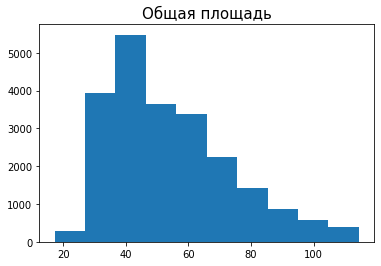


Таблица корреляции


,total_area
total_images,0.115212
last_price,0.702639
last_price_mln,0.702639
total_area,1.000000
rooms,0.758400
ceiling_height,0.138918
floors_total,-0.075250
living_area,0.945566
floor,-0.024653
is_apartment,0.031007


In [103]:
column = 'total_area'

print(column)
print(df[column].describe())
print()
median = np.median(df[column])
lower_quartile = np.percentile(df[column], 25)
upper_quartile = np.percentile(df[column], 75)
iqr = upper_quartile - lower_quartile
print('Полутора межквартильных расстояний равно', iqr.round(0))
lower_value = df[df[column] >= (lower_quartile - 1.5 * iqr)][column].min()
print("Минимум значимой выборки =", lower_value)
print("Число значений за пределами минимума =",
      df[df[column] <= lower_quartile-1.5*iqr][column].size)
upper_value = df[df[column] <= (upper_quartile + 1.5 * iqr)][column].max()
print("Максимум значимой выборки =", upper_value)
print("Число значений за пределами максимума =",
      df[df[column] >= upper_quartile+1.5*iqr][column].size)
plt.hist(df[column], range=(lower_value, upper_value))
plt.title('Общая площадь', fontsize=15)
plt.show()
print()
print('Таблица корреляции')
display(df.corr()[column].to_frame())

В целом площадь была рассмотрена на предыдущих этапах. Минимальное значение площади в выборке - 17,2 квадратных метров. Несмотря на то, что есть квартиры с площадью более 800 кв.м., значимая выборка ограничивается 114,5 кв.м. В соответствии с таблицей корреляции площадь - главный фактор определения цены. 

##### Цена

last_price_mln
count    23449.000000
mean         6.517503
std          9.754422
min          0.430000
25%          3.430000
50%          4.650000
75%          6.800000
max        420.000000
Name: last_price_mln, dtype: float64

Полутора межквартильных расстояний равно 3.0
Минимум значимой выборки = 0.43
Число значений за пределами минимума = 0
Максимум значимой выборки = 11.85
Число значений за пределами максимума = 2040


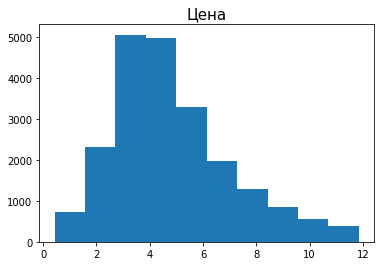


Таблица корреляции


,last_price_mln
total_images,0.111924
last_price,1.000000
last_price_mln,1.000000
total_area,0.702639
rooms,0.391923
ceiling_height,0.111431
floors_total,-0.007004
living_area,0.624909
floor,0.027591
is_apartment,0.030129


In [104]:
column = 'last_price_mln'

print(column)
print(df[column].describe())
print()
median = np.median(df[column])
lower_quartile = np.percentile(df[column], 25)
upper_quartile = np.percentile(df[column], 75)
iqr = upper_quartile - lower_quartile
print('Полутора межквартильных расстояний равно', iqr.round(0))
lower_value = df[df[column] >= (lower_quartile - 1.5 * iqr)][column].min()
print("Минимум значимой выборки =", lower_value)
print("Число значений за пределами минимума =",
      df[df[column] <= lower_quartile-1.5*iqr][column].size)
upper_value = df[df[column] <= (upper_quartile + 1.5 * iqr)][column].max()
print("Максимум значимой выборки =", upper_value)
print("Число значений за пределами максимума =",
      df[df[column] >= upper_quartile+1.5*iqr][column].size)
plt.hist(df[column], range=(lower_value, upper_value))
plt.title('Цена', fontsize=15)
plt.show()
print()
print('Таблица корреляции')
display(df.corr()[column].to_frame())

На начальном этапе работы мы убрали из выборки квартиры с ценой в 760 млн руб, в выборке имеются квартиры со стоимостью 420 млн руб. - мы не стали их убирать, так как возможно это нормальные цифры для центра города. Значимая выборка начинается с 430 тыс. руб. и заканчивается 11,85 млн руб. Больше всего на цену влияет площадь и количество комнат.

##### Комнаты

rooms
count    23449.000000
mean         2.072967
std          1.078467
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Полутора межквартильных расстояний равно 2.0
Минимум значимой выборки = 0
Число значений за пределами минимума = 0
Максимум значимой выборки = 6
Число значений за пределами максимума = 192


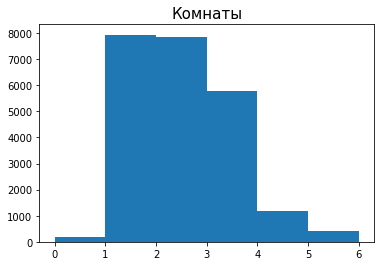


Таблица корреляции


,rooms
total_images,0.098287
last_price,0.391923
last_price_mln,0.391923
total_area,0.758400
rooms,1.000000
ceiling_height,0.083441
floors_total,-0.227815
living_area,0.825241
floor,-0.151334
is_apartment,0.000435


In [105]:
column = 'rooms'

print(column)
print(df[column].describe())
print()
median = np.median(df[column])
lower_quartile = np.percentile(df[column], 25)
upper_quartile = np.percentile(df[column], 75)
iqr = upper_quartile - lower_quartile
print('Полутора межквартильных расстояний равно', iqr.round(0))
lower_value = df[df[column] >= (lower_quartile - 1.5 * iqr)][column].min()
print("Минимум значимой выборки =", lower_value)
print("Число значений за пределами минимума =",
      df[df[column] <= lower_quartile-1.5*iqr][column].size)
upper_value = df[df[column] <= (upper_quartile + 1.5 * iqr)][column].max()
print("Максимум значимой выборки =", upper_value)
print("Число значений за пределами максимума =",
      df[df[column] >= upper_quartile+1.5*iqr][column].size)
plt.hist(df[column], range=(lower_value, upper_value), bins=6)
plt.title('Комнаты', fontsize=15)
plt.show()
print()
print('Таблица корреляции')
display(df.corr()[column].to_frame())

Мы видим, что большинство квартир имеют 1 или 2 комнаты. Есть 192 квартиры с количеством комнат больше 6, что незначительно для общей выборки. Комнаты важный, но косвенный фактор определения итоговой цены, так как количество комнат определют площадь квартиры. 

##### Высота потолка

ceiling_height
count    14407.000000
mean         2.761995
std          0.927332
min          2.200000
25%          2.520000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

Полутора межквартильных расстояний равно 0.28
Минимум значимой выборки = 2.2
Число значений за пределами минимума = 0
Максимум значимой выборки = 16
Число значений за пределами максимума = 805


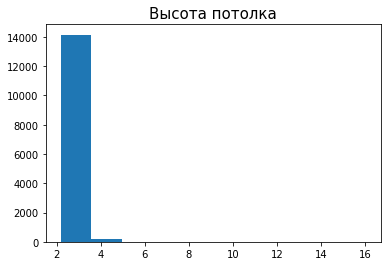


Таблица корреляции


,ceiling_height
total_images,0.004219
last_price,0.111431
last_price_mln,0.111431
total_area,0.138918
rooms,0.083441
ceiling_height,1.000000
floors_total,-0.034332
living_area,0.132599
floor,-0.018737
is_apartment,0.080950


In [106]:
print('ceiling_height')
print(df[df['ceiling_height'].notna()]['ceiling_height'].describe())
print()
median = np.median(df[df['ceiling_height'].notna()]['ceiling_height'])
lower_quartile = np.percentile(
    df[df['ceiling_height'].notna()]['ceiling_height'], 25)
upper_quartile = np.percentile(
    df[df['ceiling_height'].notna()]['ceiling_height'], 75)
iqr = upper_quartile - lower_quartile
print('Полутора межквартильных расстояний равно', iqr.round(3))
lower_value = df[df['ceiling_height'].notna() & (
    df['ceiling_height'] >= (lower_quartile - 1.5 * iqr))]['ceiling_height'].min()
print("Минимум значимой выборки =", lower_value)
print("Число значений за пределами минимума =", df[df['ceiling_height'].notna(
) & (df['ceiling_height'] <= lower_quartile-1.5*iqr)]['ceiling_height'].size)
upper_value = df[df['ceiling_height'].notna() & (
    df['ceiling_height'] <= (upper_quartile + 1.5 * iqr))][column].max()
print("Максимум значимой выборки =", upper_value)
print("Число значений за пределами максимума =", df[df['ceiling_height'].notna(
) & (df['ceiling_height'] >= upper_quartile+1.5*iqr)]['ceiling_height'].size)
plt.hist(df[df['ceiling_height'].notna()]['ceiling_height'],
         range=(lower_value, upper_value))
plt.title('Высота потолка', fontsize=15)
plt.show()
print()
print('Таблица корреляции')
display(df[df['ceiling_height'].notna()].corr()['ceiling_height'].to_frame())

На основании тех объявлений, где высота потолков в квартире указана, можно сделать вывод, что высота потолков - очень незначимый фактор при определении цены, но тем не менее он есть. Большинство квартир имееют высоту потолков до 3.2 метров. Но есть квартиры и с большей высотой потолков - их 805. 

##### Выводы

Анализ показывает, что наиважнейшим фактором определения цены является площадь. Немалозначимыми факторами является наличие прудов и парков поблизости.

#### Задача: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?""

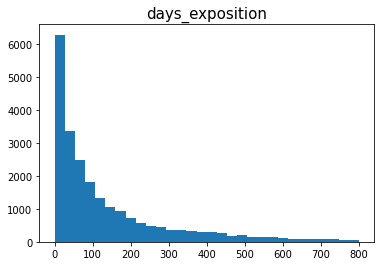

count    23449.000000
mean       156.613971
std        213.735717
min          0.000000
25%         22.000000
50%         73.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [107]:
plt.hist(df['days_exposition'], bins=30, range=(0, 800))
plt.title('days_exposition', fontsize=15)
plt.show()
print()
display(df['days_exposition'].describe())

Не забываем, что мы меняли 3000 NaN на нули

In [108]:
display(df[df['days_exposition'] > 0]['days_exposition'].describe())

count    20290.000000
mean       180.997585
std        219.959556
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Если убрать нули, то медиана возраст с 73 дней до 95 дней.

In [109]:
df2 = df[df['days_exposition'] > 0]

In [110]:
lower_quartile = np.percentile(df2['days_exposition'], 25)
upper_quartile = np.percentile(df2['days_exposition'], 75)
iqr = upper_quartile - lower_quartile
upper_value = df2[df2['days_exposition'] <= (
    upper_quartile + 1.5 * iqr)]['days_exposition'].max()
lower_value = df2[df2['days_exposition'] >= (
    lower_quartile - 1.5 * iqr)]['days_exposition'].min()
print("Минимум значимой выборки =", lower_value)
print("Максимум значимой выборки =", upper_value)

Минимум значимой выборки = 1.0
Максимум значимой выборки = 512.0


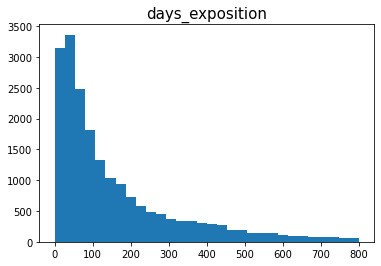

In [111]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=30, range=(0, 800))
plt.title('days_exposition', fontsize=15)
plt.show()

Рассмотрим внимательнее интервал до года

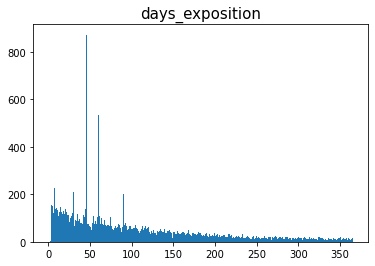

In [112]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=365, range=(0, 365))
plt.title('days_exposition', fontsize=15)
plt.show()

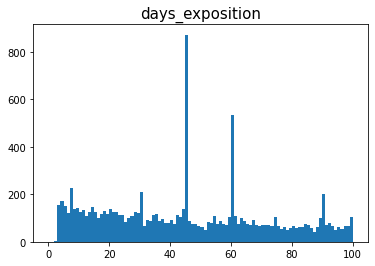

In [113]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=100, range=(0, 100))
plt.title('days_exposition', fontsize=15)
plt.show()

Наблюлаются резкие выбросы в районе 7, 30, 45, 60 и 90 дней. Сузим интервал.

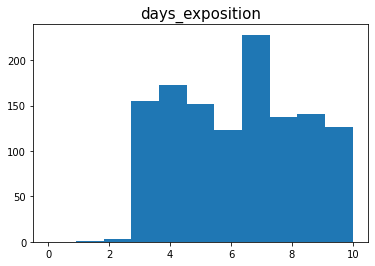

In [114]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=11, range=(0, 10))
plt.title('days_exposition', fontsize=15)
plt.show()

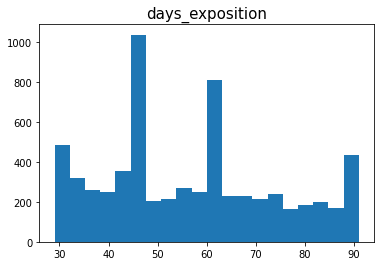

In [115]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=20, range=(29, 91))
plt.title('days_exposition', fontsize=15)
plt.show()

Рассмотрим каждый выброс по отдельности

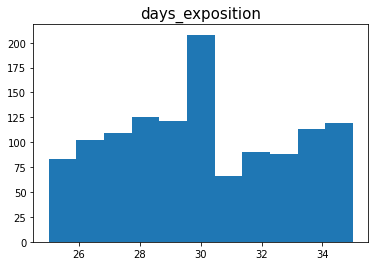

In [116]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=11, range=(25, 35))
plt.title('days_exposition', fontsize=15)
plt.show()

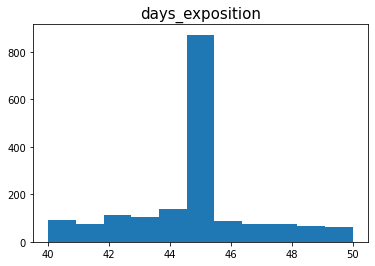

In [117]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=11, range=(40, 50))
plt.title('days_exposition', fontsize=15)
plt.show()

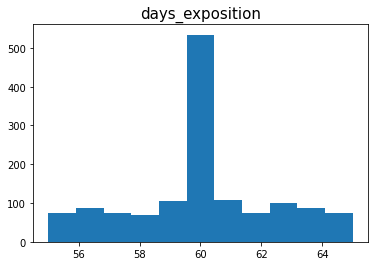

In [118]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=11, range=(55, 65))
plt.title('days_exposition', fontsize=15)
plt.show()

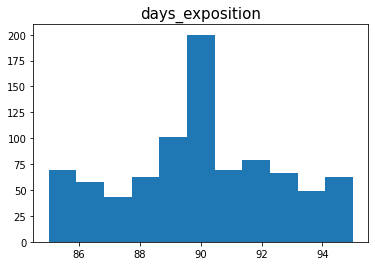

In [119]:
plt.hist(df[df['days_exposition'] > 0]
         ['days_exposition'], bins=11, range=(85, 95))
plt.title('days_exposition', fontsize=15)
plt.show()

Предполагаем, что объявления автоматически снимаются через 7, 45, 60 и 90 дней. Большое кол-во квартир в данных дня сдвигают среднюю и медину от нормального уровня. Для дальнейшего анализа избавимся от выбросов.

,days,counts
0,0.0,3159
1,1.0,1
2,2.0,3
3,3.0,155
4,4.0,173
5,5.0,152
6,6.0,123
7,7.0,228
8,8.0,137
9,9.0,141


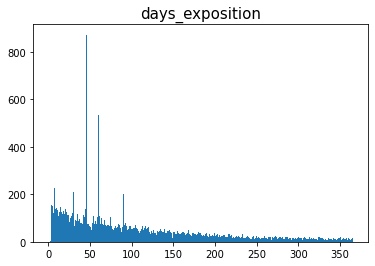

In [120]:
days_exposition = df['days_exposition'].value_counts().rename_axis(
    'days').reset_index(name='counts').sort_values(by='days').reset_index(drop=True)
display(days_exposition.head(10))
days_exposition.at[0, 'counts'] = 0
plt.hist(days_exposition['days'], bins=365, range=(
    0, 365), weights=days_exposition['counts'])
plt.title('days_exposition', fontsize=15)
plt.show()

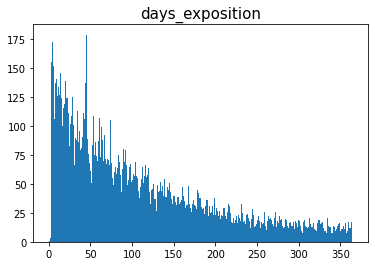

In [121]:
mean_7 = days_exposition[(days_exposition['days'] < 7) |
                         ((days_exposition['days'] > 7) & (days_exposition['days'] < 14))]['counts'].mean()
days_exposition.at[7, 'counts'] = mean_7
mean_30 = days_exposition[((days_exposition['days'] > 25) & (days_exposition['days'] < 30)) |
                          ((days_exposition['days'] > 30) & (days_exposition['days'] < 35))]['counts'].mean()
days_exposition.at[30, 'counts'] = mean_30
mean_45 = days_exposition[((days_exposition['days'] > 40) & (days_exposition['days'] < 45)) |
                          ((days_exposition['days'] > 45) & (days_exposition['days'] < 50))]['counts'].mean()
days_exposition.at[45, 'counts'] = mean_45
mean_60 = days_exposition[((days_exposition['days'] > 55) & (days_exposition['days'] < 60)) |
                          ((days_exposition['days'] > 60) & (days_exposition['days'] < 65))]['counts'].mean()
days_exposition.at[60, 'counts'] = mean_60
mean_90 = days_exposition[((days_exposition['days'] > 85) & (days_exposition['days'] < 90)) |
                          ((days_exposition['days'] > 90) & (days_exposition['days'] < 95))]['counts'].mean()
days_exposition.at[90, 'counts'] = mean_90

plt.hist(days_exposition['days'], bins=366, range=(
    0, 365), weights=days_exposition['counts'])
plt.title('days_exposition', fontsize=15)
plt.show()

Выбросов больше нет

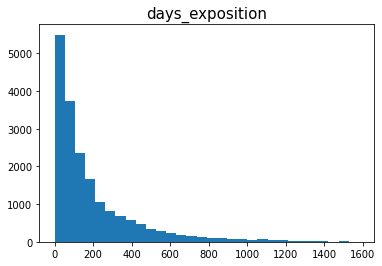

In [122]:
plt.hist(days_exposition['days'], bins=30, weights=days_exposition['counts'])
plt.title('days_exposition', fontsize=15)
plt.show()

,days
0,1
1,2
2,2
3,2
4,3
...,...
18795,1135
18796,1136
18797,1137
18798,1138


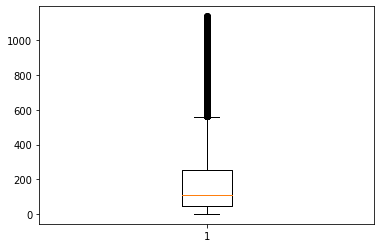

In [123]:
newdata = np.repeat(days_exposition['days'], days_exposition['counts']).rename_axis(
    'days').reset_index(name='delete')
newdata = newdata.drop(columns='delete')
display(newdata)
plt.boxplot(newdata)
plt.show()

In [124]:
lower_quartile = np.percentile(newdata['days'], 25)
upper_quartile = np.percentile(newdata['days'], 75)
iqr = upper_quartile - lower_quartile
upper_value = newdata[newdata['days'] <= (
    upper_quartile + 1.5 * iqr)]['days'].max()
lower_value = newdata[newdata['days'] >= (
    lower_quartile - 1.5 * iqr)]['days'].min()
print("Минимум значимой выборки =", lower_value)
print("Максимум значимой выборки =", upper_value)

Минимум значимой выборки = 1
Максимум значимой выборки = 561


##### Выводы

Если опираться на значения боксплота, то можно предположить, что уж очень долго продаются квартиры, чьи объявления размещены дольше 565 дней. Слишком быстрых продаж, видимо, не бывает. С другой стороны, если объявления автоматически снимаются, возможно квартиры продали, тогда слишком долгими являются объявления, размещенные в течение 512 дней. (не очень-то большая разница)

#### Задача: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года."

In [125]:
display(df.corr()['last_price_mln'])

total_images           0.111924
last_price             1.000000
last_price_mln         1.000000
total_area             0.702639
rooms                  0.391923
ceiling_height         0.111431
floors_total          -0.007004
living_area            0.624909
floor                  0.027591
is_apartment           0.030129
studio                -0.027628
open_plan             -0.009453
kitchen_area           0.526312
balcony                0.004422
airports_nearest      -0.028766
cityCenters_nearest   -0.228340
parks_around3000       0.169129
parks_nearest         -0.020742
ponds_around3000       0.172536
ponds_nearest         -0.103856
days_exposition        0.061265
sqm_price              0.729954
day_of_week           -0.002858
month                  0.000689
year                  -0.046716
living_share           0.015412
kitchen_share         -0.089161
Name: last_price_mln, dtype: float64

Как уже было сказано ранее, больше всего цена зависит от площади. На втором месте комнаты. На третьем - удаленность от центра. Еще есть небольшая зависимость от парков и прудов. 

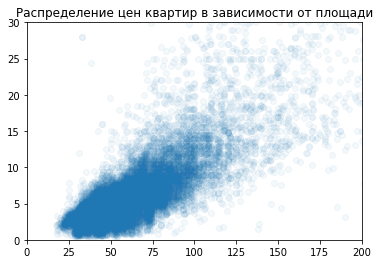

In [126]:
plt.scatter(x=df['total_area'], y=df['last_price_mln'], alpha=0.05)
plt.ylim(0, 30)
plt.xlim(0, 200)
plt.title('Распределение цен квартир в зависимости от площади')
plt.show()

На графике сверху хорошо заметна зависимость цены от площади.

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23449 entries, 0 to 23496
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23449 non-null  int64         
 1   last_price            23449 non-null  float64       
 2   last_price_mln        23449 non-null  float64       
 3   total_area            23449 non-null  float64       
 4   first_day_exposition  23449 non-null  datetime64[ns]
 5   rooms                 23449 non-null  int64         
 6   ceiling_height        14407 non-null  float64       
 7   floors_total          23449 non-null  float64       
 8   living_area           23449 non-null  float64       
 9   floor                 23449 non-null  int64         
 10  is_apartment          23449 non-null  bool          
 11  studio                23449 non-null  bool          
 12  open_plan             23449 non-null  bool          
 13  kitchen_area    

In [128]:
df.pivot_table(values='last_price_mln',
               index='category_of_floor', aggfunc=['mean', 'median'])

,mean,median
,last_price_mln,last_price_mln
category_of_floor,,
Другой,6.683857,4.85
Первый,4.813186,3.90
Последний,7.138077,4.30


Грубые подсчеты показывают, что на первом этаже квартиры самые дешевые. А на последнем самые дорогие.

In [129]:
df.pivot_table(values='last_price_mln', index='day_of_week',
               aggfunc=['median', 'mean'])

,median,mean
,last_price_mln,last_price_mln
day_of_week,,
0,4.650,6.527500
1,4.730,6.398550
2,4.700,6.643400
3,4.650,6.713386
4,4.550,6.363227
5,4.555,6.601491
6,4.550,6.265662


Зависимости от дня недели, кажется, нет

,median,mean
,last_price_mln,last_price_mln
month,,
1,4.6000,6.667287
2,4.6500,6.470308
3,4.6500,6.372898
4,4.8000,6.751048
5,4.5000,6.608330
6,4.4000,6.329809
7,4.6500,6.647086
8,4.5800,6.354982


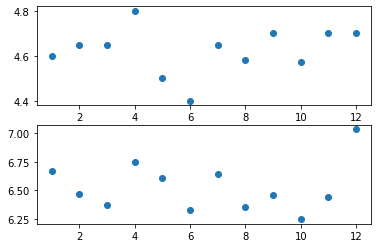

In [130]:
month_corr = df.pivot_table(values='last_price_mln',
                            index='month', aggfunc=['median', 'mean'])
display(month_corr)
fig, (ax1, ax2) = plt.subplots(2)
ax1.scatter(x=month_corr.index, y=month_corr['median'])
ax2.scatter(x=month_corr.index, y=month_corr['mean'])
plt.show()

Есть ощущение, что объявления выложенные в апреле, июле и сентябре имеют цену выше.

In [131]:
df.pivot_table(values='last_price_mln', index='year',
               aggfunc=['median', 'mean'])

,median,mean
,last_price_mln,last_price_mln
year,,
2014,7.8685,12.175169
2015,5.3000,8.594196
2016,4.5500,6.838344
2017,4.5000,6.496935
2018,4.5750,5.964612
2019,5.0500,6.790608


В 2014 г. средний ценник был намного выше. Видимо, это связано как-то с ситуацией в экономике.

"Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'."

,locality_name,count,mean,median
0,санкт-петербург,15578,114682.0,104703.0
1,пушкин,369,103126.0,100000.0
2,деревня кудрово,298,92516.0,91930.0
3,посeлок парголово,326,90135.0,91580.0
4,посeлок мурино,516,85607.0,85878.0
5,посeлок шушары,437,78525.0,76667.0
6,колпино,337,75481.0,74725.0
7,всеволожск,393,68635.0,65789.0
8,гатчина,303,68625.0,67647.0
9,выборг,235,58238.0,58308.0


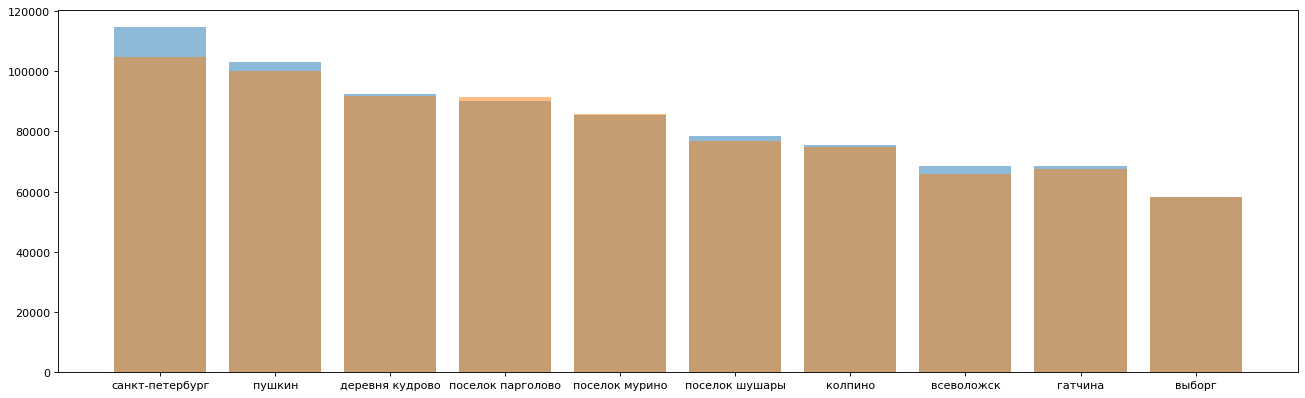

In [132]:
topList_of_localities = df.pivot_table(index='locality_name', values='sqm_price', aggfunc=[
                                       'count', 'mean', 'median']).rename_axis('locality_name').reset_index()
topList_of_localities.columns = topList_of_localities.columns.droplevel(1)
topList_of_localities = topList_of_localities.sort_values(by='count', ascending=False).head(
    10).reset_index(drop=True).sort_values(by='mean', ascending=False).reset_index(drop=True)
topList_of_localities['mean'] = topList_of_localities['mean'].round(0)
topList_of_localities['median'] = topList_of_localities['median'].round(0)
display(topList_of_localities)
plt.figure(figsize=(20, 6), dpi=80)
plt.bar(x=topList_of_localities['locality_name'],
        height=topList_of_localities['mean'], alpha=0.5)
plt.bar(x=topList_of_localities['locality_name'],
        height=topList_of_localities['median'], alpha=0.5)
plt.show()

Самая высокая стоимость жилья в Санкт-Петербурге. Не смоневались. А вот самая маленькая в Выборге

"Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона."

In [133]:
spb_df = df.query('locality_name == "санкт-петербург"').reset_index(drop=True)
display(spb_df.head(5))

,total_images,last_price,last_price_mln,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqm_price,day_of_week,month,year,category_of_floor,living_share,kitchen_share
0,20,13000000.0,13.000,108.0,2019-03-07,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0,120370.370370,3,3,2019,Другой,0.472222,0.231481
1,10,5196000.0,5.196,56.0,2015-08-20,2,NaN,5.0,34.300000,4,False,False,False,8.300000,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,Другой,0.612500,0.148214
2,0,64900000.0,64.900,159.0,2015-07-24,3,NaN,14.0,100.426617,9,False,False,False,21.074021,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,Другой,0.631614,0.132541
3,2,10000000.0,10.000,100.0,2018-06-19,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,Другой,0.320000,0.410000
4,5,7915000.0,7.915,71.6,2019-04-18,2,NaN,24.0,41.879245,22,False,False,False,18.900000,2.0,санкт-петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,0.0,110544.692737,3,4,2019,Другой,0.584906,0.263966


In [134]:
spb_df['cityCenters_nearest_km'] = np.round(
    spb_df['cityCenters_nearest'] / 1000, 0)
spb_city_distant = spb_df.pivot_table(
    values='last_price_mln', index='cityCenters_nearest_km', aggfunc='mean').reset_index()
display(spb_city_distant.head(10))

,cityCenters_nearest_km,last_price_mln
0,0.0,31.449116
1,1.0,21.397318
2,2.0,17.910030
3,3.0,11.137395
4,4.0,12.267578
5,5.0,14.498225
6,6.0,15.360199
7,7.0,14.800512
8,8.0,9.938532
9,9.0,6.976919


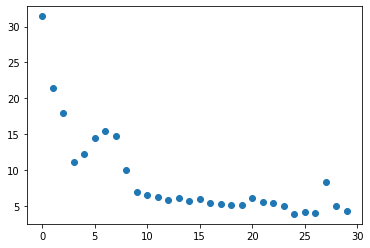

In [135]:
plt.scatter(x=spb_city_distant['cityCenters_nearest_km'],
            y=spb_city_distant['last_price_mln'])
plt.show()

Можно заметить на 8-9 километре, будем считать это центром.

"Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"

In [136]:
spb_cityCenter = spb_df.query(
    'cityCenters_nearest_km <= 8').reset_index(drop=True)
corr_table_spb_cityCenter = spb_cityCenter.corr()['last_price_mln'].rename_axis(
    'atribute').reset_index(name='cityCenter_value')
corr_table_spb_general = spb_df.corr()['last_price_mln'].rename_axis(
    'atribute').reset_index(name='general_value')
corr_table_comp = corr_table_spb_cityCenter.merge(corr_table_spb_general)
display(corr_table_comp)

,atribute,cityCenter_value,general_value
0,total_images,0.136910,0.104086
1,last_price,1.000000,1.000000
2,last_price_mln,1.000000,1.000000
3,total_area,0.690830,0.708317
4,rooms,0.365169,0.402186
5,ceiling_height,0.081288,0.134414
6,floors_total,0.026740,-0.068153
7,living_area,0.600413,0.631753
8,floor,0.111723,-0.003471
9,is_apartment,0.043866,0.027940


Площадь и количество комнат в центре города имеют чуть меньшую значимость, чем в целом для города. А вот количество фото квартир в центре имеют большую значимость. Больше фото = есть что, показать. Возможно, в центре города цена может зависить от интерьера. Кроме того, центре города большое значение отдается этажу: выше этаж - дороже квартира. Удаленность от центра в центральной части города имеет меньшую значимость. Логично, когда ты и так в центре.

### Общий вывод

Анализ показывает, что наиважнейшим фактором определения цены является площадь. При этом кажется правильным, в случае моделировании цены, фильтровать квартиры на старте: "подчиняющиеся общим правилам" и "индивидуальные" предложения - для них действуют немного другие правила определения цены, которые следует рассматривать отдельно. К "подчиняющимся общим правилам" можно отнести квартиры со следующими параметрами:
- площадь до 115 метров
- количество комнат до 7
- высота потолка до 3,2 метров

Также при моделировании стоит учитывать близость квартиры к центру. Для квартир, не находящихся в "центральной зоне" города это имеет большое значение при определении цены. Также для таких квартир большое значение имеют водоемы и парки. А вот для квартир в центре почти не имеет значения близость к центру, и менее важны водоемы и парки.